# Florence2 Object Detection Inference

In [1]:
# - Packages
import numpy as np
import torch
import cv2
import os

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from torch.utils.data import Dataset, DataLoader

import torch
import supervision as sv

from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)

In [2]:
# - Global Variables
data_dir= Path("./snemi/" )
raw_image_dir = data_dir / 'image_pngs'
seg_image_dir = data_dir / 'seg_pngs'
test_image_dir = data_dir / 'image_test_pngs'


CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

label_num = 170

## - Define Dataloader
BATCH_SIZE = 5
NUM_WORKERS = 0

checkpoint_dir = './model_checkpoints/epoch_1000'
model = AutoModelForCausalLM.from_pretrained(checkpoint_dir, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(checkpoint_dir, trust_remote_code=True)


##  Data Preparation

In [3]:
# - Prepare dataset
# - Finetuning Dataset Processing
## - Prepare dataset
data = []
for ff, name in enumerate(os.listdir(raw_image_dir)):
    data.append({'image': raw_image_dir / f'image{ff:04d}.png', 'annotation': seg_image_dir / f'seg{ff:04d}.png'})
# - split train dataset and validation dataset
valid_data = data[80:]
data = data[:80]

## - Convert Mask to Bounding Boxes
def convert_mask2box(mask:np.ndarray):
    inds = np.unique(mask)[1:] # load all indices

    masks = [] 
    for ind in inds:
        masks.append(mask == ind)

    masks = np.array(masks)
    masks_tensor = torch.from_numpy(masks)

    boxes = masks_to_boxes(masks_tensor)
    valid_input_boxes = boxes.numpy()
    return valid_input_boxes

## - normalize location
def normalize_loc(prefix:str, instance_type:str, image_path:str, mask:np.ndarray, input_boxes:np.ndarray):
    x_res = mask.shape[0]
    y_res = mask.shape[1]
    normal_boxes = [[box[0] / x_res * 1000, box[1]/ y_res * 1000, box[2] / x_res * 1000, box[3] / x_res * 1000] for box in input_boxes]
    normal_boxes = np.rint(normal_boxes)
    suffix = ''
    count = 0
    for i in range(len(normal_boxes)):
        #- reach the max sequence length 1024
        if count == label_num:
            break
        x1 = int(normal_boxes[i][0])
        y1 = int(normal_boxes[i][1])
        x2 = int(normal_boxes[i][2])
        y2 = int(normal_boxes[i][3])
        suffix += f"{instance_type}<loc_{x1}><loc_{y1}><loc_{x2}><loc_{y2}>"
        count += 1
        

    
    return {"image": image_path,"prefix": prefix, "suffix": suffix }

## - Prepare all training dataset and validation dataset
def prepare_dataset(data, instance_type, prefix):
    dataset = []
    for element in data:
        image_path = element['image']
        seg_path = element['annotation']
        mask = np.array(Image.open(seg_path))
        input_boxes = convert_mask2box(mask)
        curated_data = normalize_loc(prefix, instance_type, image_path, mask, input_boxes)
        dataset.append(curated_data)
    return dataset

train_dataset = prepare_dataset(data, 'neuron', "<OD>")
val_dataset = prepare_dataset(valid_data, 'neuron', "<OD>")

# - Initialize Dataset and Dataloader

## - Detection Dataset Class (Dataset Preparation)
class DetectionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        image = cv2.imread(str(data['image']))
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

## - Define Dataloader

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(train_dataset)
val_dataset = DetectionDataset(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=False)

## Object Detection Inference

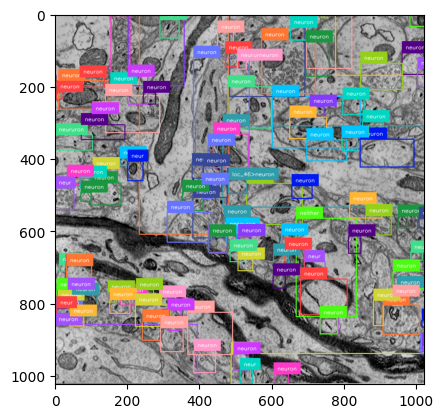

In [4]:
# - EM Validation Image Sample Inference
image = cv2.imread(str(valid_data[0]['image']))
image = Image.fromarray(image)
task = "<OD>"
text = "<OD>"

inputs = processor(
    text=text, 
    images=image, 
    return_tensors="pt"
).to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=2048,
    num_beams=3)
generated_text = processor.batch_decode(
    generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(
    generated_text, 
    task=task, 
    image_size=image.size)
detections = sv.Detections.from_lmm(
    sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(
    color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
plt.imshow(image)

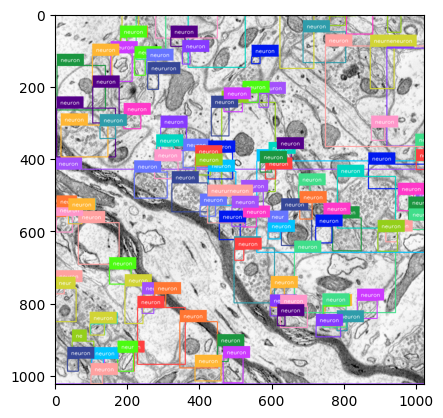

In [5]:
# - EM Test Image Sample Inference
image = cv2.imread(str(test_image_dir / 'image0001.png'))
image = Image.fromarray(image)
task = "<OD>"
text = "<OD>"

inputs = processor(
    text=text, 
    images=image, 
    return_tensors="pt"
).to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=2048,
    num_beams=3)
generated_text = processor.batch_decode(
    generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(
    generated_text, 
    task=task, 
    image_size=image.size)
detections = sv.Detections.from_lmm(
    sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(
    color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
plt.imshow(image)

In [7]:
response

{'<OD>': {'bboxes': [[0.5120000243186951,
    429.5680236816406,
    1023.488037109375,
    1023.488037109375],
   [228.864013671875, 812.5440673828125, 360.96002197265625, 969.216064453125],
   [64.0, 577.0240478515625, 177.66400146484375, 692.7360229492188],
   [345.6000061035156, 851.4560546875, 449.0240173339844, 979.4560546875],
   [747.008056640625, 807.4240112304688, 805.3760375976562, 865.7920532226562],
   [193.0240020751953,
    752.1280517578125,
    243.20001220703125,
    856.5760498046875],
   [150.01600646972656,
    705.0240478515625,
    210.4320068359375,
    747.008056640625],
   [461.31201171875, 244.22401428222656, 609.7920532226562, 491.0080261230469],
   [662.0160522460938, 659.968017578125, 942.592041015625, 826.8800659179688],
   [5.63200044631958, 142.84800720214844, 139.7760009765625, 265.72802734375],
   [368.1280212402344,
    0.5120000243186951,
    526.8480224609375,
    147.96800231933594],
   [686.592041015625, 49.66400146484375, 804.35205078125, 134.65